In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from joblib import dump
from dynaconf import settings
import pyodbc
import logging
from joblib import Memory
from train_and_pred import *

In [2]:
df_nmi_test_X = None
df_nmi_test_y = None

def load_data(nmi_id, start_date, end_date, facts=[], test_dates=[]):
    global df_nmi_test_X, df_nmi_test_y
    df_nmi_X, df_nmi_Y = get_train_test_data(nmi_id, start_date, end_date)
    df_nmi_test_X, df_nmi_train_X, df_nmi_test_y, df_nmi_train_y = train_test_split(df_nmi_X, df_nmi_Y, test_dates)
    df_nmi_train_X, df_nmi_test_X, df_future, df_LLM, codes = integrate_domain_knowledge(nmi_id, start_date, end_date, df_nmi_train_X, df_nmi_test_X, facts)
    df_nmi_train_X, df_nmi_test_X, df_nmi_train_y, df_nmi_test_y = prep_train_test_data(df_nmi_train_X, df_nmi_test_X, df_nmi_train_y, df_nmi_test_y)
    model, rmse_train, mape_train = train_model(df_nmi_train_X, df_nmi_train_y, nmi_id, facts)
    df_nmi_test_y_pred, rmse_test, mape_test = predict_model(model, df_nmi_test_X, df_nmi_test_y)   
    df_future_dates, y_pred = forecast_nmi_consumption(model, nmi_id, start_date, end_date, df_future, codes)

    return model, mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, df_LLM, df_future

def get_all_meter_details():
    df_meter_info = get_meter_info()
    meter_dict = {row['NetworkID'] : row['Name'] for _, row in df_meter_info.iterrows()}
    campus_dict = {row['NetworkID'] : row['CampusKey'] for _, row in df_meter_info.iterrows()}
    return meter_dict, campus_dict

In [3]:
meter_dict, campus_dict = get_all_meter_details()

In [9]:
import json
with open('metadata/facts.json', 'r') as f:
    facts_data = json.load(f)

with open('metadata/train_test_split.json', 'r') as f:
    test_split_data = json.load(f)


USE_FACTS = True

# for nmi_id, nmi_name in meter_dict.items():
for i in range(1,2):
    nmi_id = 2
    campus_key = campus_dict[nmi_id]
    start_date = '20180101'
    end_date   = '20250601'

    # Get facts for the current campus
    facts = facts_data.get(str(nmi_id), [])
    test_split = test_split_data.get(str(nmi_id), {})
    
    if USE_FACTS:
        model, mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, df_LLM, df_LLM_future = load_data(nmi_id, start_date, end_date, facts=facts, test_dates=test_split)
    else:
        model, mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, _, _ = load_data(nmi_id, start_date, end_date, test_dates=test_split)





Fact: During Covid-19, there was a period of where campus was closed and hence the consumption was lower than expected
Code: import pandas as pd

# Assuming df_LLM is already defined and contains a 'DatePlot' column
# Convert 'DatePlot' to datetime if it's not already
df_LLM['DatePlot'] = pd.to_datetime(df_LLM['DatePlot'])

# Define the start and end dates for the COVID-19 campus closure period
covid_start_date = pd.to_datetime('2020-03-15')
covid_end_date = pd.to_datetime('2020-08-31')

# Create a new column 'CovidClosure' that is 1 if the date is within the closure period, otherwise 0
df_LLM['CovidClosure'] = df_LLM['DatePlot'].apply(lambda x: 1 if covid_start_date <= x <= covid_end_date else 0)

# Display the first few rows of the dataframe to verify the new column
print(df_LLM.head())
         DateKey   DatePlot  ApparentTemperature  AirTemperature  \
1459  20220101.0 2022-01-01            25.814583       27.354167   
1460  20220102.0 2022-01-02            22.802083       23.827083

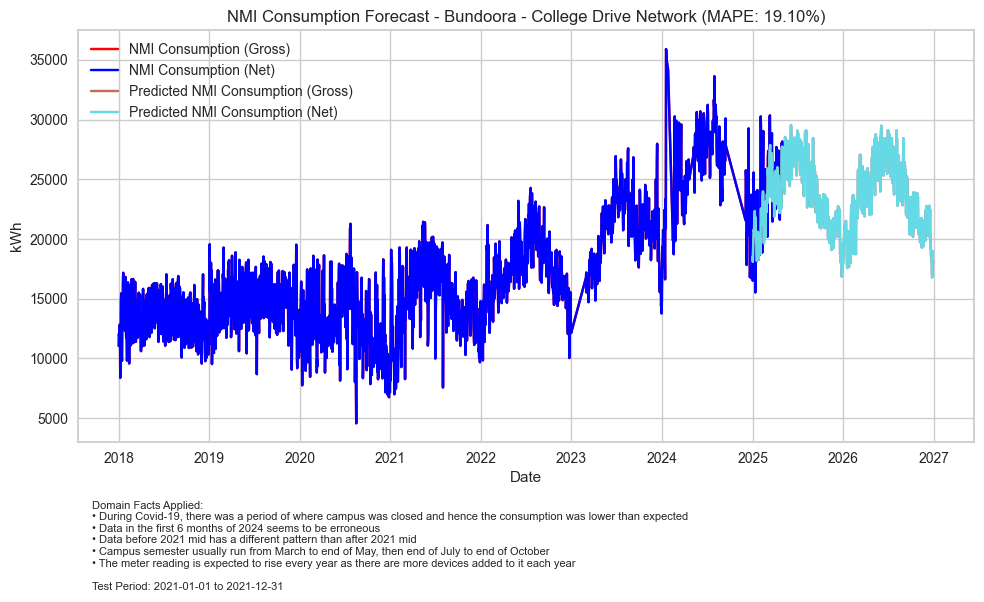

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_nmi_Y['DatePlot'], df_nmi_Y['consumption'], label='NMI Consumption (Gross)', color='red')
ax.plot(df_nmi_Y['DatePlot'], df_nmi_Y['metered_consumption'], label='NMI Consumption (Net)', color='blue')
ax.plot(df_future_dates['DatePlot'], y_pred, label='Predicted NMI Consumption (Gross)', color=(0.75, 0.43, 0.38))
ax.plot(
    df_future_dates['DatePlot'],
    y_pred ,
    color=(0.4, 0.85, 0.9),
    label='Predicted NMI Consumption (Net)'
)

ax.set_title(f"NMI Consumption Forecast - {meter_dict[nmi_id]} (MAPE: {mape_test:.2%})")
ax.set_xlabel("Date")
ax.set_ylabel("kWh")
ax.legend()
ax.grid(True)

# Add facts and test dates information at the bottom of the plot
info_text = ""
if USE_FACTS and facts:
    info_text += "Domain Facts Applied:\n" + "\n".join([f"• {fact}" for fact in facts])
else:
    info_text += "Domain Facts: Disabled"

if test_split:
    test_start = str(test_split.get('test_start_date', ''))
    test_end = str(test_split.get('test_end_date', ''))
    if test_start and test_end:
        # Format dates for display
        test_start_formatted = f"{test_start[:4]}-{test_start[4:6]}-{test_start[6:]}"
        test_end_formatted = f"{test_end[:4]}-{test_end[4:6]}-{test_end[6:]}"
        info_text += f"\n\nTest Period: {test_start_formatted} to {test_end_formatted}"

plt.figtext(0.1, 0, info_text, fontsize=8, wrap=True, ha='left', va='bottom')
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

In [6]:
print(df_LLM.columns)
print(df_LLM_future.columns)


Index(['DateKey', 'DatePlot', 'ApparentTemperature', 'AirTemperature',
       'DewPointTemperature', 'RelativeHumidity', 'Day', 'Weekday',
       'IsWeekend', 'IsHoliday', 'DOWInMonth', 'WeekOfMonth', 'WeekOfYear',
       'Month', 'Quarter', 'Year', 'set', 'CampusClosed', 'ErroneousFlag',
       'PatternChange', 'IsSemester'],
      dtype='object')
Index(['DateKey', 'DatePlot', 'ApparentTemperature', 'AirTemperature',
       'DewPointTemperature', 'RelativeHumidity', 'Day', 'Weekday',
       'IsWeekend', 'IsHoliday', 'DOWInMonth', 'WeekOfMonth', 'WeekOfYear',
       'Month', 'Quarter', 'Year', 'CampusClosed', 'ErroneousFlag',
       'PatternChange', 'IsSemester'],
      dtype='object')


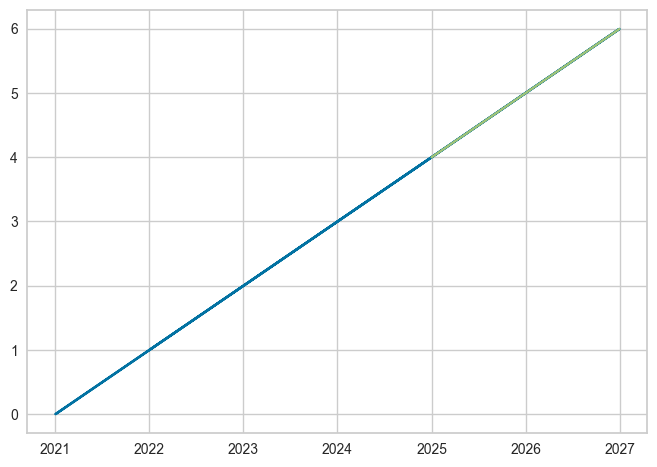

In [15]:
feature = 'YearsSinceStart'
df_LLM['DatePlot'] = pd.to_datetime(df_LLM['DatePlot'])
df_LLM_future['DatePlot'] = pd.to_datetime(df_LLM_future['DatePlot'])
plt.plot(df_LLM['DatePlot'], df_LLM[feature])
plt.plot(df_LLM_future['DatePlot'], df_LLM_future[feature])


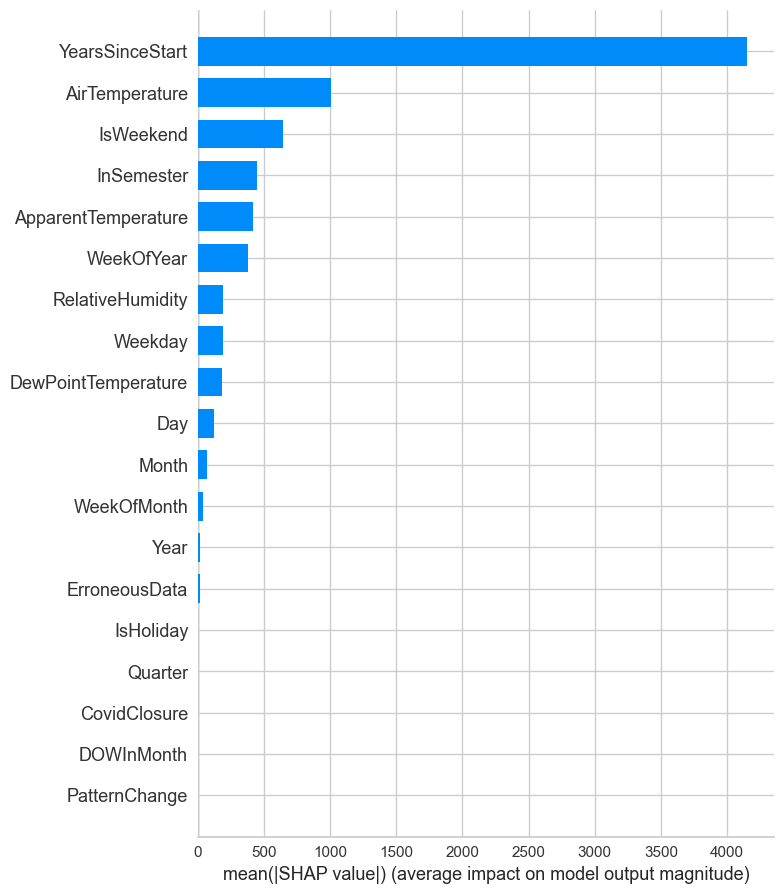

<Figure size 800x550 with 0 Axes>

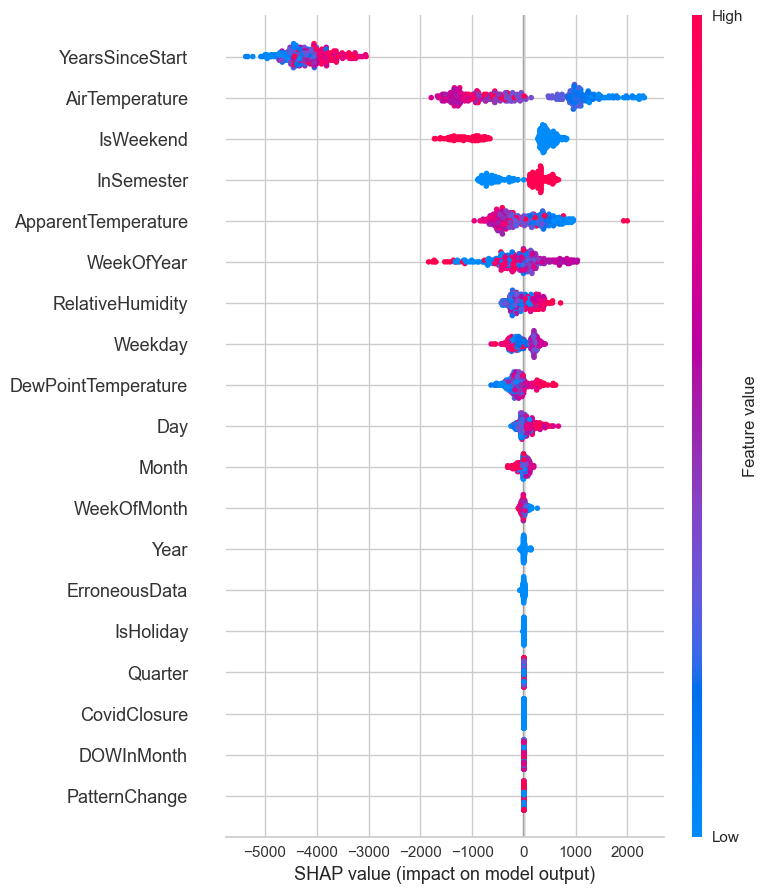

<Figure size 800x550 with 0 Axes>

In [14]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
# X_test = df_LLM[df_LLM['DatePlot'].dt.year == 2022].drop(['DatePlot', 'Consumption'], axis=1)
shap_values = explainer.shap_values(df_nmi_test_X)

# Create beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, df_nmi_test_X, plot_type="bar")
plt.tight_layout()
plt.show()

# Create detailed beeswarm plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, df_nmi_test_X)
plt.tight_layout()
plt.show()
